<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignment 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [75]:
##### Your Code Here #####

from tensorflow.keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [76]:
from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

In [83]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
model = Sequential([
    Flatten(),
    Dense(15, input_dim=13, activation="relu"),
    Dense(1, activation="relu")
])


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

model.fit(x=X_train, 
        y=y_train, 
        epochs=150, 
        validation_data=(X_test, y_test))

Train on 404 samples, validate on 102 samples
Epoch 1/150
404/404 [==============================] - 0s 696us/sample - loss: 586.1605 - mse: 586.1605 - val_loss: 615.8578 - val_mse: 615.8578
Epoch 2/150
404/404 [==============================] - 0s 75us/sample - loss: 586.1605 - mse: 586.1605 - val_loss: 615.8578 - val_mse: 615.8578
Epoch 3/150
404/404 [==============================] - 0s 90us/sample - loss: 586.1605 - mse: 586.1605 - val_loss: 615.8578 - val_mse: 615.8578
Epoch 4/150
404/404 [==============================] - 0s 46us/sample - loss: 586.1605 - mse: 586.1604 - val_loss: 615.8578 - val_mse: 615.8578
Epoch 5/150
404/404 [==============================] - 0s 69us/sample - loss: 586.1605 - mse: 586.1605 - val_loss: 615.8578 - val_mse: 615.8578
Epoch 6/150
404/404 [==============================] - 0s 73us/sample - loss: 586.1605 - mse: 586.1605 - val_loss: 615.8578 - val_mse: 615.8578
Epoch 7/150
404/404 [==============================] - 0s 103us/sample - loss: 586.1605 -

In [5]:
hist = model.history.history

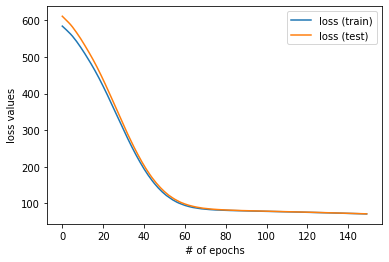

In [30]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(hist['loss'], label='loss (train)')
plt.plot(hist['val_loss'], label='loss (test)')
# plt.xticks(np.arange(0, 5), ('1','2','3','4','5'))
plt.xlabel('# of epochs')
plt.ylabel('loss values')
plt.legend();

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()


model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred)

(22.77423909605731, 18.16551049349646)

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- The number of nodes in your output layer should equal the number of classes you want to predict for Fashion-MNIST.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [55]:
##### Your Code Here #####
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [56]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [57]:
X_train.shape

(60000, 28, 28)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
model = Sequential([
    Flatten(),
    Dense(784, input_dim=28, activation="relu"),
    Dense(784, activation="relu"),
    Dense(784, activation="relu"),
    Dense(10, activation="softmax")
])


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x=X_train, 
        y=y_train, 
        epochs=15, 
        validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 17s 285us/sample - loss: 1.5518 - accuracy: 0.7848 - val_loss: 0.5136 - val_accuracy: 0.8202
Epoch 2/15
60000/60000 [==============================] - 17s 278us/sample - loss: 0.4627 - accuracy: 0.8346 - val_loss: 0.4370 - val_accuracy: 0.8495
Epoch 3/15
60000/60000 [==============================] - 16s 269us/sample - loss: 0.4186 - accuracy: 0.8518 - val_loss: 0.4441 - val_accuracy: 0.8454
Epoch 4/15
60000/60000 [==============================] - 16s 268us/sample - loss: 0.3964 - accuracy: 0.8590 - val_loss: 0.4084 - val_accuracy: 0.8555
Epoch 5/15
60000/60000 [==============================] - 17s 278us/sample - loss: 0.3790 - accuracy: 0.8670 - val_loss: 0.4300 - val_accuracy: 0.8541
Epoch 6/15
60000/60000 [==============================] - 16s 273us/sample - loss: 0.3673 - accuracy: 0.8701 - val_loss: 0.4231 - val_accuracy: 0.8447
Epoch 7/15
60000/60000 [====================

In [60]:
hist1 = model.history.history

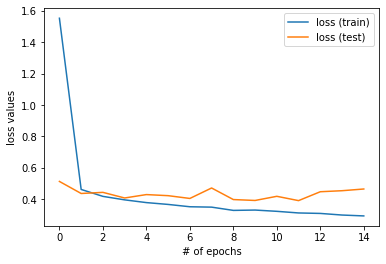

In [64]:
plt.plot(hist1['loss'], label='loss (train)')
plt.plot(hist1['val_loss'], label='loss (test)')
# plt.xticks(np.arange(0, 5), ('1','2','3','4','5'))
plt.xlabel('# of epochs')
plt.ylabel('loss values')
plt.legend();

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.